### Imports

In [80]:
import requests as rq
import pandas as pd
import numpy as np
import datetime as dt
import traceback as tb
import seaborn as sb

from scipy import optimize
from scipy import integrate

### Download & plot data

In [73]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(int(d['dailyconfirmed']))
        r['deceased'].append(int(d['dailydeceased']))
        r['recovered'].append(int(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)

In [74]:
df.head()

,date,confirmed,deceased,recovered
0,2020-01-30,1,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,1,0,0
4,2020-02-03,1,0,0


In [75]:
# remove first 37 days of data. not consequential.
fdf = df[37:][:]
fdf.head()

,date,confirmed,deceased,recovered
37,2020-03-07,3,0,0
38,2020-03-08,5,0,0
39,2020-03-09,9,0,0
40,2020-03-10,15,0,1
41,2020-03-11,8,0,0


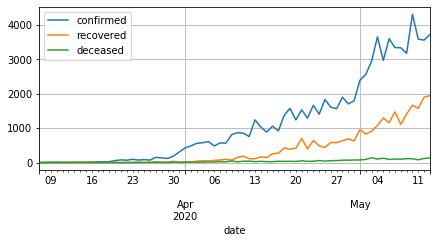

In [76]:
# plot downloaded data
fdf.plot(
    x='date',
    y=['confirmed', 'recovered', 'deceased'],
    figsize=(7,3),
    grid=True
)

### Compute & plot Re (effective reproduction number)

In [77]:
fdf['re'] = fdf['confirmed'] / fdf['confirmed'].shift(1, fill_value=1)
fdf['sma_re'] = fdf['re'].rolling(7, min_periods=1, center=True).mean().rolling(7, min_periods=1, center=True).mean()
fdf.head()

,date,confirmed,deceased,recovered,re,sma_re
37,2020-03-07,3,0,0,3.000000,1.744742
38,2020-03-08,5,0,0,1.666667,1.653413
39,2020-03-09,9,0,0,1.800000,1.574489
40,2020-03-10,15,0,1,1.666667,1.509952
41,2020-03-11,8,0,0,0.533333,1.375006


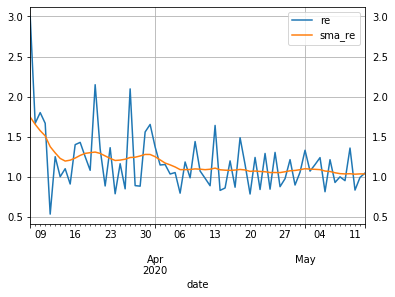

In [79]:
ax = fdf.plot(
    x='date',
    y=['re', 'sma_re'],
    grid=True
)
ax.tick_params(labeltop=False, labelright=True)

### Learning to fit a sample curve

In [68]:
# define a simple function
def y(x, a, b):
    return a * x * x + b

# generate multiplier between 0.9 and 1.1 to noisy test data for fitting
import random
def m():
    return 0.9 + 0.2 * random.random()

test_data = [2 * x * x * m() + 10 for x in range(10)] # so a=2 and b=10 in test data
print("actual output:", [f"{y(i, 2, 10):0.2f}" for i in range(10)])
print("values to fit:", [f"{i:0.2f}" for i in test_data])

# fit test data to function and try to find params
out = optimize.curve_fit(y, np.arange(10), test_data)
print ("param:", out[0])
print ("covar:\n", out[1])

actual output: ['10.00', '12.00', '18.00', '28.00', '42.00', '60.00', '82.00', '108.00', '138.00', '172.00']
values to fit: ['10.00', '11.96', '17.74', '28.14', '44.11', '62.38', '88.45', '116.63', '139.77', '178.88']
param: [ 2.08587851 10.35996481]
covar:
 [[ 7.76771438e-04 -2.21379864e-02]
 [-2.21379864e-02  1.19102373e+00]]


### SIR Model

In [82]:
def diff_eqns(y, t, beta, gamma, N):
    St, It, Rt = y
    dsdt = -beta * St * It / N
    didt = beta * St * It / N - gamma * It
    drdt = gamma * It
    return [dsdt, didt, drdt]

def sir_model(t, beta, gamma, I0, N):
    S0 = N - I0
    R0 = 0
    out = integrate.odeint(diff_eqns, (S0, I0, R0), t, args=(beta, gamma, N))
    S, I, R = out.T
    return S, I, R

### Sample plot of SIR model

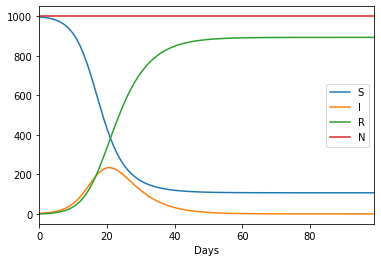

In [96]:
I0 = 3
N = 1000
beta = 0.5
gamma = 0.2
days = np.arange(100)
S, I, R = sir_model(days, beta, gamma, I0, N)

r = {
    'Days': days,
    'S': S,
    'I': I,
    'R': R
}

df = pd.DataFrame(r)
df['N'] = df['S'] + df['I'] + df['R']

df.plot(
    'Days',
    ['S', 'I', 'R', 'N']
)

### Try to fit the sample output back

In [98]:
def sir_model_apartment_inf(days, beta, gamma):
    I0 = 3
    N = 1000
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

days = np.arange(100)
I = sir_model_apartment_inf(days, 0.5, 0.2)
op.curve_fit(sir_model_apartment_inf, df['Days'], df['I'])

(array([0.5, 0.2]), array([[4.23127455e-34, 1.88000344e-34],
        [1.88000344e-34, 2.08497191e-34]]))

### Try to fit real data

In [101]:
def sir_model_india_inf(days, beta, gamma):
    I0 = 3 #mar 3
    N = 1300000000 #130 crores
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

params, cov = op.curve_fit(sir_model_india_inf, fdf.index, fdf.confirmed)
print(params)
print(cov)
print(params[0]/params[1])

[1.13794687 1.02581923]
[[8256.01995582 8255.66660629]
 [8255.66660629 8255.31327267]]
1.1093054610673845
